In [1]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

from itertools import count
from collections import namedtuple
from torch.autograd import Variable


# parser = argparse.ArgumentParser(description='PyTorch actor-critic example')
# parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
#                     help='discount factor (default: 0.99)')
# parser.add_argument('--seed', type=int, default=543, metavar='N',
#                     help='random seed (default: 1)')
# parser.add_argument('--render', action='store_true',
#                     help='render the environment')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='interval between training status logs (default: 10)')
# args = parser.parse_args()

gamma_rl = 0.99

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from gridworld import GridworldEnv

In [4]:
env = GridworldEnv(shape=(5, 5))

In [5]:
#state_dim = 2 * len(env.state)
state_dim = int(env.nS * 2)
action_dim = int(env.nA)

hidden_layer1_size = 50
hidden_layer2_size = 50

lambda_baseline = 0.1 #best 0.1

entropy_weights = {
    "Alice":0.0,
    "Bob":0.00,
}

eps = 1e-3

In [6]:
def entropy_term(probs):
    return -torch.sum(probs * torch.log(probs))

In [7]:
SavedAction = namedtuple('SavedAction', ['action', 'prob', 'value'])
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(state_dim, hidden_layer1_size)
        nn.init.xavier_normal(self.affine1.weight)
        self.action_head = nn.Linear(hidden_layer2_size, action_dim)
        nn.init.xavier_normal(self.action_head.weight)
        self.value_head = nn.Linear(hidden_layer2_size, 1)
        nn.init.xavier_normal(self.value_head.weight)

        self.saved_actions = []
        self.rewards = []

    def forward(self, s, s_star=None):
        x_onehot = torch.zeros((1, state_dim))
        x_onehot[0][s] = 1
        if(not (s_star is None)):
            x_onehot[0][state_dim // 2 + s_star] = 1
        x_onehot = Variable(x_onehot)
        x = F.relu(self.affine1(x_onehot))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores), state_values
    
    def select_action(self, state, s_star, cache_action=True):
        #state = torch.from_numpy(state).int().unsqueeze(0)
        probs, state_value = self.forward(state, s_star)
        action = probs.multinomial()
        if(cache_action == True):
            self.saved_actions.append(SavedAction(action, probs, state_value))
        return action.data

In [8]:
# def select_action(state, s_star, model):
#     #state = torch.from_numpy(state).int().unsqueeze(0)
#     probs, state_value = model(state, s_star)
#     action = probs.multinomial()
#     model.saved_actions.append(SavedAction(action, probs, state_value))
#     return action.data

In [9]:
def update_params(model, optimizer, who="Bob"):
    R = 0
    saved_actions = model.saved_actions
    value_loss = 0
    entropy_loss = 0
    rewards = []
    for r in model.rewards[::-1]:
        R = r + gamma_rl * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    for (action, probs, value), r in zip(saved_actions, rewards):
        reward = r - value.data[0, 0]
        action.reinforce(reward)
        value_loss += lambda_baseline * F.mse_loss(value, Variable(torch.Tensor([r])))
        entropy_loss += -entropy_weights[who] * entropy_term(probs)

    optimizer.zero_grad()
    final_nodes = [value_loss] + [entropy_loss] + list(map(lambda p: p.action, saved_actions))
    gradients = [torch.ones(1)] + [torch.ones(1)] + [None] * len(saved_actions)
    
    autograd.backward(final_nodes, gradients)
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]


In [10]:
def check_equivalence(s1, s2, eps=1e-9):
    return np.sum((s1 - s2) ** 2) < eps   

In [11]:
def set_random_s0(env):
    #rand_s0 = np.random.randint(12, 13)
    rand_s0 = np.random.randint(1, env.nS - 1)
    
    for i in range(len(env.isd)):
        env.isd[i] = 0
    
    env.isd[rand_s0] = 1  

In [12]:
class Alice:
    def __init__(self, Alice_type):
        self.type = Alice_type
    
    def get_action_probs(self, env, s):
        if(self.type == 'left_top_corner'):
            if(s == 0):
                return np.array([0, 0, 0, 0, 1])
            if(s % int(np.sqrt(env.nS)) == 0):
                return np.array([1, 0, 0, 0, 0])
            if(s < int(np.sqrt(env.nS))):
                return np.array([0, 0, 0, 1, 0])
            return np.array([0.5, 0, 0, 0.5, 0])
        else:
            if(s == env.nS - 1):
                return np.array([0, 0, 0, 0, 1])
            if((s + 1) % int(np.sqrt(env.nS)) == 0):
                return np.array([0, 0, 1, 0, 0])
            if(s + int(np.sqrt(env.nS)) >= env.nS):
                return np.array([0, 1, 0, 0, 0])
            return np.array([0, 0.5, 0.5, 0, 0])

    def select_action(self, env, s):
        action_probs = self.get_action_probs(env, s)
        action = np.random.choice(np.arange(5), p=action_probs)
        
        return action

    def precompute_v_function(self, env):
        self.v = np.zeros(env.nS)
        for s in range(len(self.v)):
            if(self.type == 'left_top_corner'):
                self.v[s] = -(s % int(np.sqrt(env.nS)) + s // int(np.sqrt(env.nS)))
            else:
                self.v[s] = (-((int(np.sqrt(env.nS)) - (s % int(np.sqrt(env.nS))) - 1) 
                        + (int(np.sqrt(env.nS)) - s // int(np.sqrt(env.nS)) - 1)))

    def v_function(self, s):
        return self.v[s]

In [13]:
def is_done(env, s):
    return (s == env.nS - 1) or (s == 0)

def get_episode_reward(env, model, who, tmax,  s_star=None):
    policy_episode_reward = 0.0
    set_random_s0(env)
    env.reset()
    s = env.s
    gamma_factor = 1
    for i in range(tmax):
        if(is_done(env, s)):
            break
        if(who == "Alice"):
            a = model.select_action(env, s)
        else:
            a = model.select_action(s, s_star, cache_action=False)[0, 0]
        s, reward, _, _= env.step(a)
        policy_episode_reward += reward * gamma_factor
        gamma_factor *= gamma_rl
    
    return policy_episode_reward
        
        
def get_policy_reward_estimation(env, model, who, episodes_to_estimate, tmax, s_star=None):
    episode_reward_estiomation = []
    
    for ep in range(episodes_to_estimate):
        episode_reward_estiomation.append(get_episode_reward(env, model, who, tmax, s_star))
    
    return np.array(episode_reward_estiomation)

In [14]:
Alice_left_corner = Alice("left_top_corner")
Alice_left_corner.precompute_v_function(env)
Alice_right_corner = Alice("right_bottom_corner")
Alice_right_corner.precompute_v_function(env)

In [15]:
def self_play_episode(env, tmax, model_Alice, model_Bob, pretraining_type="Repeat", is_gridworld=True):
    
#     if(pretraining_type == "Repeat" and is_gridworld):
#         set_random_s0(env)
    
#     s0 = env.reset()# + 1
#     if pretraining_type == "Reverse":
#         s_star = s0
    #Alice term
    tA = 0
    done = False
    while True:
        tA = tA + 1
        s = env.s
        
        a = model_Alice.select_action(env, s)
        if a == env.action_space.n or tA >= tmax:
            if(pretraining_type == "Repeat"):
                s_star = env.s# + 1
                env.reset()
            
            break
        state, _, done, _= env.step(a)
    
    tB = 0
    done = False
    while True:
        if check_equivalence(np.array(env.s), np.array(s_star))  or (tB + tA >= tmax):
            break
        tB += 1
        a = model_Bob.select_action(env.s, s_star)
        state, _, done, _= env.step(a[0, 0])
        model_Bob.rewards.append(0)
    
    R_Bob = -scale_self_play * tB
    if(len(model_Bob.saved_actions)):
        if(len(model_Bob.rewards)):
            model_Bob.rewards[-1] = R_Bob
        else:
            model_Bob.rewards.append(R_Bob)

    if(len(model_Bob.saved_actions)):
        update_params(model_Bob, optimizer_Bob, "Bob")
    
    return R_Bob, tB, env.s
    

In [16]:
#lr_Alice = 1e-4
lr_Bob = 5e-4

scale_self_play = 0.1

#Best lr_Bob 1e-2, scale_self_play = 0.1

In [17]:
model_Bob = Policy(state_dim, action_dim)

#optimizer_Alice = optim.SGD(model_Alice.parameters(), lr=lr_Alice)
#optimizer_Bob = optim.SGD(model_Bob.parameters(), lr=lr_Bob)

#optimizer_Alice = optim.RMSprop(model_Alice.parameters(), alpha=0.97, eps=1e-6, lr=lr_Alice)
optimizer_Bob = optim.RMSprop(model_Bob.parameters(), alpha=0.97, eps=1e-6, lr=lr_Bob)
#optimizer_Bob = optim.Adam(model_Bob.parameters(), lr=lr_Bob)

In [18]:
from tqdm import tnrange
from random import choice

def choose_Alice(models_Alice, s0, strategy="dummy"):
    if(strategy == "dummy"):
        return models_Alice[np.random.randint(len(models_Alice))]
    if(strategy == "v-based"):
        best_Alice_indxs = []
        best_Alice_v = -np.inf
        
        for i, Alice in enumerate(models_Alice):
            if(Alice.v_function(s0) > best_Alice_v):
                best_Alice_indx = [i]
                best_Alice_v = Alice.v_function(s0)
            if(Alice.v_function(s0) == best_Alice_v):
                best_Alice_indx.append(i)
                
        return models_Alice[choice(best_Alice_indx)]

from collections import defaultdict
    
def pretrain_model(env, tmax, models_Alice, model_Bob, total_episodes, stats_term, pretraining_type="Repeat"):
    rewards = []
    episode_time = []
    finish_states = []
    Alices_times_choice = defaultdict(int)
    for i in range(total_episodes):
        #print("Episode %d:" % (i + 1))
        set_random_s0(env)
        s0 = env.reset()# + 1
        model_Alice = choose_Alice(models_Alice, s0, strategy="v-based")
        Alices_times_choice[model_Alice.type] += 1
        
        res = self_play_episode(env, tmax, model_Alice, model_Bob, pretraining_type)
        if((i + 1) % stats_term == 0):     
            rewards.append(res[0])
            episode_time.append(res[1])
            finish_states.append(res[2])
    
    print(Alices_times_choice)
    return model_Bob, np.array(rewards), np.array(episode_time), np.array(finish_states)

In [19]:
# import copy
# model_Bob_old = copy.deepcopy(model_Bob)

In [20]:
def draw_value_anotate(ax, env, s, value, font_color='c'):
    i = (s) // env.shape[1]
    j = (s) % env.shape[1]
    
    ax.annotate("%.2f" % value, xy=(j-0.3, i), color='c', fontsize=11)

def is_terminal(env, s):
    return s == 0 or s == env.nS - 1

def play_n_episodes(n, env, model, s_star, tmax=40):
    state_dist_list = []
    for i in range(n):
        set_random_s0(env)
        env.reset()
        #print(env.s)
        state_dist_episode = np.zeros(env.shape)
        for j in range(tmax):
            s = env.s
            state_dist_episode[s // env.shape[0]][s % env.shape[1]] += 1
            if(is_terminal(env, env.s)):
                break
            probs, state_value = model(s, s_star)
            action = probs.multinomial().data
            env.step(action[0][0])
        state_dist_list.append(state_dist_episode)
    
    state_dist = np.zeros(env.shape)
    
    for dist in state_dist_list:
        state_dist += dist
    
    return state_dist / n, state_dist_list  

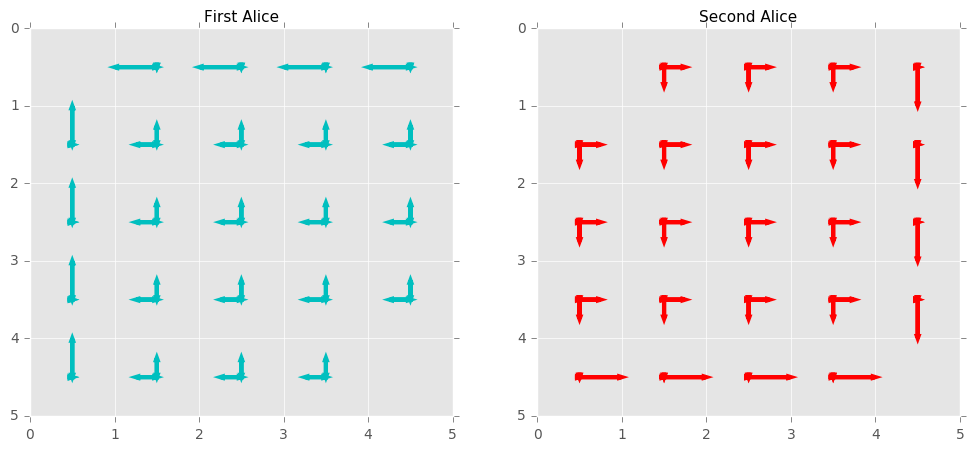

In [21]:
import matplotlib

def draw_direction_probs(ax, env, s, p, scale_arrow=0.5, arrow_width=3, arrow_color='c', eps=1e-5):
    i = (s) // env.shape[1]
    j = (s) % env.shape[1]
    
    ax.arrow(j + 0.5, i + 0.5, p[1] * scale_arrow + eps, 0, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, 0, p[2] * scale_arrow + eps, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, -p[3] * scale_arrow + eps, 0, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, 0, -p[0] * scale_arrow + eps, linewidth=arrow_width, color=arrow_color, length_includes_head=True)

    
matplotlib.style.use("ggplot")
fig, ax = subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].set_xticks(np.arange(0, 6))
ax[0].set_yticks(np.arange(0, 6))
heat_map = np.zeros((5, 5))
heat_map[0][0] += 1
heat_map[4][4] += 1
ax[1].set_xticks(np.arange(0, 6))
ax[1].set_yticks(np.arange(0, 6))
#ax[0].gca().invert_yaxis()
#ax[1].gca().invert_yaxis()

#ax.arrow(0 + 0.5, 0 + 0.5, 0, -1, linewidth=5, color='c', length_includes_head=True)

for s in range(0, env.nS):
    if(s == 0 or s == 24):
        continue
    else:
        draw_direction_probs(ax[0], env, s, Alice_left_corner.get_action_probs(env, s), arrow_color='c')
        draw_direction_probs(ax[1], env, s, Alice_right_corner.get_action_probs(env, s), arrow_color='r')

ax[0].invert_yaxis()
ax[1].invert_yaxis()

ax[0].set_title("First Alice", fontsize=11)
ax[1].set_title("Second Alice", fontsize=11)
#plt.savefig("presa_example")

In [22]:
models_Alice = [Alice_right_corner, Alice_left_corner]

In [23]:
model_Bob = Policy(state_dim, action_dim)

#optimizer_Alice = optim.SGD(model_Alice.parameters(), lr=lr_Alice)
#optimizer_Bob = optim.SGD(model_Bob.parameters(), lr=lr_Bob)

#optimizer_Alice = optim.RMSprop(model_Alice.parameters(), alpha=0.97, eps=1e-6, lr=lr_Alice)
optimizer_Bob = optim.RMSprop(model_Bob.parameters(), alpha=0.97, eps=1e-6, lr=lr_Bob)

In [24]:
plots_dir = "plots_union/v-based-strategy_random_init_100/"
try:
    os.mkdir(plots_dir)
except:
    pass

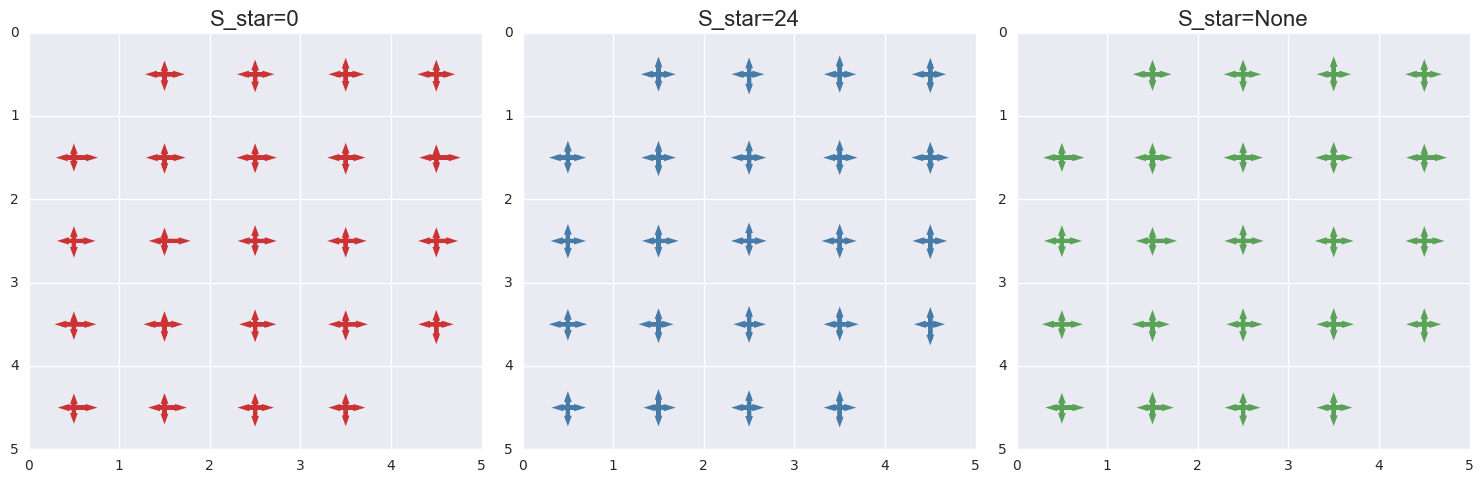

In [25]:
import seaborn as sns;
sns.set(color_codes=True)
fig, ax = subplots(nrows=1, ncols=3, figsize=(15, 5))
s_stars = [0, env.nS - 1, None]
#colors = ["c", "red", "green"]
colors = sns.color_palette("Set1", n_colors=3, desat=.75)
for j, s_star in enumerate(s_stars):
    for s in range(1, env.nS - 1):
        
        ax[j].set_xticks(np.arange(0, 6))
        ax[j].set_yticks(np.arange(0, 6))
        probs, state_value = model_Bob(s, s_star)
        draw_direction_probs(ax[j], env, s, probs[0].data, arrow_color=colors[j])
        ax[j].set_title("S_star={}".format(str(s_star)), fontsize=16)
        ax[j].invert_yaxis()

fig.tight_layout()

plt.savefig(os.path.join(plots_dir, "action_prob_plot{}".format(0)))

In [26]:
def draw_reward_curves(ax, env, models, models_anotations, tmax, previous_rewards, estimation_episodes_num=500):
    
    colors = sns.color_palette("Set1", n_colors=len(models_anotations), desat=.75)
    
    current_models_rewards = previous_rewards
    for i, model in enumerate(models):
        if("Alice" in models_anotations[i]):
            current_models_rewards[i].append(get_policy_reward_estimation(env, model, who="Alice", 
                                                                     episodes_to_estimate=estimation_episodes_num, tmax=tmax))
        else:
            current_models_rewards[i].append(get_policy_reward_estimation(env, model, who="Bob", 
                                                                     episodes_to_estimate=estimation_episodes_num, tmax=tmax))
    if(len(current_models_rewards[0]) > 1):
        for i in range(len(models_anotations)):
            data = np.array(current_models_rewards)[i, :, :].T
            sns.tsplot(data=data, ax=ax, condition=models_anotations[i], color=colors[i], time=np.arange(1, len(current_models_rewards[0]) + 1))
            #ax.plot(np.array(previous_rewards)[:, i], label=models_anotations[i], linewidth=3)
        
        ax.set_xticks
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Estimated reward")
    
        ax.legend(loc="best")
    
    return current_models_rewards

defaultdict(<class 'int'>, {'right_bottom_corner': 52, 'left_top_corner': 48})
defaultdict(<class 'int'>, {'right_bottom_corner': 53, 'left_top_corner': 47})
defaultdict(<class 'int'>, {'right_bottom_corner': 52, 'left_top_corner': 48})
defaultdict(<class 'int'>, {'right_bottom_corner': 51, 'left_top_corner': 49})
defaultdict(<class 'int'>, {'right_bottom_corner': 51, 'left_top_corner': 49})


/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


defaultdict(<class 'int'>, {'right_bottom_corner': 54, 'left_top_corner': 46})
defaultdict(<class 'int'>, {'right_bottom_corner': 55, 'left_top_corner': 45})
defaultdict(<class 'int'>, {'right_bottom_corner': 55, 'left_top_corner': 45})
defaultdict(<class 'int'>, {'right_bottom_corner': 57, 'left_top_corner': 43})
defaultdict(<class 'int'>, {'right_bottom_corner': 62, 'left_top_corner': 38})
defaultdict(<class 'int'>, {'right_bottom_corner': 50, 'left_top_corner': 50})
defaultdict(<class 'int'>, {'right_bottom_corner': 48, 'left_top_corner': 52})
defaultdict(<class 'int'>, {'right_bottom_corner': 48, 'left_top_corner': 52})
defaultdict(<class 'int'>, {'right_bottom_corner': 45, 'left_top_corner': 55})
defaultdict(<class 'int'>, {'right_bottom_corner': 46, 'left_top_corner': 54})
defaultdict(<class 'int'>, {'right_bottom_corner': 57, 'left_top_corner': 43})
defaultdict(<class 'int'>, {'right_bottom_corner': 57, 'left_top_corner': 43})
defaultdict(<class 'int'>, {'right_bottom_corner': 5

[2017-12-27 16:34:48,455] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-81f7156f8800>", line 20, in <module>
    previous_rewards = draw_reward_curves(ax, env, models, models_anotations, tmax, previous_rewards)
  File "<ipython-input-26-98c3b17afd6b>", line 16, in draw_reward_curves
    sns.tsplot(data=data, ax=ax, condition=models_anotations[i], color=colors[i], time=np.arange(1, len(current_models_rewards[0]) + 1))
  File "/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/seaborn/timeseries.py", line 284, in tsplot
    axis=0, func=estimator)
  File "/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/seaborn/algorithms.py", line 76, in bootstrap
    boot_dist.append(func(*sample, **func_kwargs))
  File "/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py", line 2909, in mea

KeyboardInterrupt: 

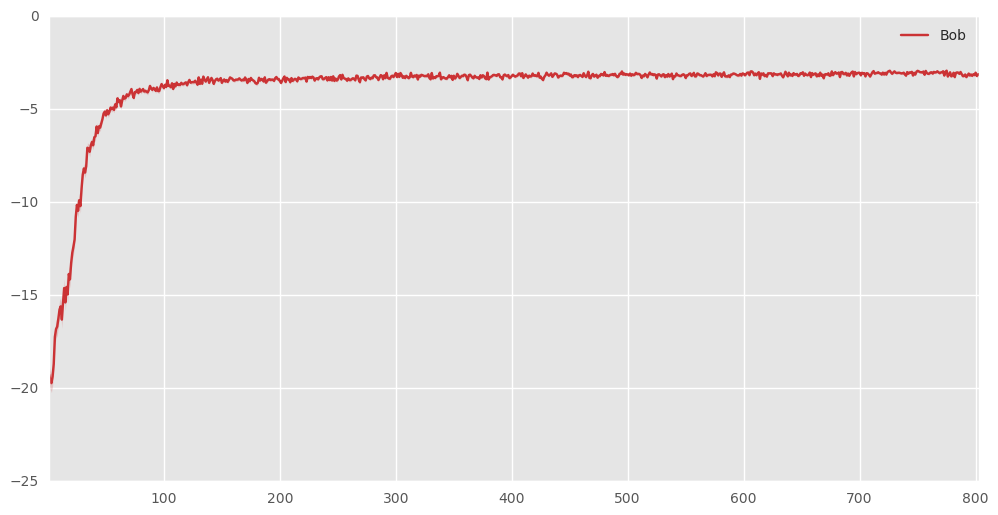

In [27]:
import matplotlib
from tqdm import tnrange
matplotlib.style.use("ggplot")
episodes_step = 100
stats_term = 1
times = 1000
start = 0
tmax = 40

models = [model_Bob, Alice_left_corner, Alice_right_corner]
previous_rewards = [[] for i in range(len(models))]

for i in tnrange(times):
    model_Bob, rewards, time, finish_states = pretrain_model(env, tmax, models_Alice, model_Bob, episodes_step, 
                                                             stats_term=stats_term, pretraining_type="Repeat")
    
    fig, ax = subplots(nrows=1, ncols=1, figsize=(12, 6))
    models = [model_Bob, Alice_left_corner, Alice_right_corner]
    models_anotations = ["Bob", "Alice left corner", "Alice right corner"]
    previous_rewards = draw_reward_curves(ax, env, models, models_anotations, tmax, previous_rewards)
    fig.tight_layout()
    plt.savefig(os.path.join(plots_dir, "rewards_curves{}".format(episodes_step * (start + i + 1))))
    plt.clf()
    
    
    #actions_prob_plot
    fig, ax = subplots(nrows=1, ncols=3, figsize=(15, 5))
    colors = ["c", "red", "green"]
    for j, s_star in enumerate(s_stars):
        for s in range(1, env.nS - 1):

            ax[j].set_xticks(np.arange(0, 6))
            ax[j].set_yticks(np.arange(0, 6))
            probs, state_value = model_Bob(s, s_star)
            draw_direction_probs(ax[j], env, s, probs[0].data, arrow_color=colors[j])
            ax[j].set_title("S_star={}".format(str(s_star)), fontsize=16)
            ax[j].invert_yaxis()
    fig.tight_layout()
    plt.savefig(os.path.join(plots_dir, "action_prob_plot{}".format(episodes_step * (start + i + 1))))
    plt.clf()
    
    #reward_time_plot
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    ax[0].plot(rewards, label="Bob's reward")
    ax[1].plot(time, label="Bob's time")
    ax[2].hist(finish_states, color='c', alpha=0.5, label="Bob")

    ax[0].set_xlabel("episode")
    ax[1].set_xlabel("episode")
    ax[1].set_ylabel("steps")
    ax[0].set_ylabel("reward")
    ax[2].set_xlabel("final state")
    ax[2].set_ylabel("distribution")
    ax[0].legend(loc="best")
    ax[1].legend(loc="best")
    ax[2].legend(loc="best")
    fig.tight_layout()
    plt.savefig(os.path.join(plots_dir, "reward_time_final{}".format(episodes_step * (start + i + 1))))
    plt.clf()
    #plt.savefig("plots_union_no_entropy_one_hot/reward_time_final{}".format(episodes_step * (start + i + 1)))
    
    #final_states_heat_map
    dense_Bob = np.zeros((5, 5))
    for finish in finish_states:
        dense_Bob[finish // 5][finish % 5] += 1

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    ax.imshow(dense_Bob, cmap='hot', interpolation='nearest')
    ax.set_title("Bob final states")

    plt.savefig(os.path.join(plots_dir, "final_states{}".format(episodes_step * (start + i + 1))))
    plt.clf()
    
    fig, ax = subplots(nrows=1, ncols=3, figsize=(12, 5))
    for j in range(3):
        ax[j].set_xticks(np.arange(0, 6))
        ax[j].set_yticks(np.arange(0, 6))
        ax[j].invert_yaxis()

    for j, s_star in enumerate([0, 24, None]):
        state_dist, state_dist_list = play_n_episodes(100, env, model_Bob, s_star)   
        for s in range(1, env.nS - 1):
            value = model_Bob(s, s_star)[1].data[0][0]
            #states_heat_map[int(s // np.sqrt(env.nS))][s % int(np.sqrt(env.nS))] = value
            draw_value_anotate(ax[j], env, s, value)
        ax[j].imshow(state_dist, cmap='hot', interpolation='nearest')
        ax[j].set_title("S_star={}".format(str(s_star)), fontsize=16)
    
    plt.savefig(os.path.join(plots_dir, "value_state_distr{}".format(episodes_step * (start + i + 1))))
    plt.clf()

In [138]:
def draw_value_anotate(ax, env, s, value, font_color='c'):
    i = (s) // env.shape[1]
    j = (s) % env.shape[1]
    
    ax.annotate("%.2f" % value, xy=(j-0.3, i), color='c', fontsize=11)

In [131]:
state_dist

array([[ 0.35,  0.18,  0.13,  0.36,  0.13],
       [ 0.35,  0.23,  0.12,  0.25,  0.11],
       [ 0.6 ,  0.16,  0.07,  0.12,  0.14],
       [ 0.62,  0.05,  0.08,  0.62,  0.65],
       [ 0.28,  0.43,  0.65,  0.46,  0.65]])

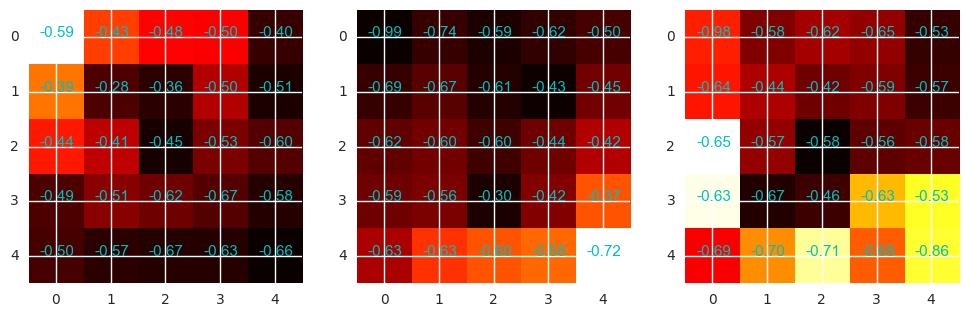

In [140]:
import seaborn as sns
fig, ax = subplots(nrows=1, ncols=3, figsize=(12, 5))
for i in range(3):
    ax[i].set_xticks(np.arange(0, 6))
    ax[i].set_yticks(np.arange(0, 6))
    ax[i].invert_yaxis()

for i, s_star in enumerate([0, 24, None]):
    state_dist, state_dist_list = play_n_episodes(100, env, model_Bob, s_star)   
    for s in range(env.nS):
        value = model_Bob(s, s_star)[1].data[0][0]
        #states_heat_map[int(s // np.sqrt(env.nS))][s % int(np.sqrt(env.nS))] = value
        draw_value_anotate(ax[i], env, s, value)
    ax[i].imshow(state_dist, cmap='hot', interpolation='nearest')
#ax[0].colorbar()

In [93]:
sns.despine(states_heat_map)

AttributeError: 'numpy.ndarray' object has no attribute 'axes'

In [60]:
states_heat_map

array([[-0.59381258, -0.43023404, -0.47775382, -0.50098127, -0.40126941],
       [-0.38833085, -0.27976575, -0.36261141, -0.49572831, -0.51082337],
       [-0.43805   , -0.41263515, -0.44584924, -0.52505875, -0.60363269],
       [-0.49151981, -0.50533783, -0.61683792, -0.67397845, -0.57913858],
       [-0.4980616 , -0.56829864, -0.66737449, -0.63027173, -0.6630401 ]])

In [27]:
# torch.save(model_Bob, 'model_Bob.pt')
# model = torch.load('model_Bob.pt')

/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
rewards = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -380, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -330, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -360]
torch.Tensor(rewards)

In [33]:
gamma

<function RandomState.gamma>

In [ ]:
w = torch.Tensor(3, 5)
nn.init.uniform(w)

In [ ]:
1